## Einleitung
Question and Answer Generation (QAG) ist ein wichtiger Anwendungsfall, bei dem automatisch Fragen und Antworten zu einem gegebenen Text generiert werden.
### Use-Case
QAG hat viele praktische Anwendungen:

- Content-Erstellung: QAG kann Content-Erstellern und Autoren dabei helfen, Inhalte effizienter zu erstellen. Anstatt manuell Fragen und Antworten zu einem Text zu formulieren, kann QAG dies automatisch erledigen.
- E-Learning: In Bildungseinrichtungen und E-Learning-Plattformen kann QAG verwendet werden, um Übungen und Quizfragen zu generieren, die das Verständnis der Schüler und Lernenden fördern.
- FAQ-Generierung: Unternehmen können QAG nutzen, um FAQs für ihre Produkte oder Dienstleistungen zu erstellen. Das spart Zeit und Ressourcen bei der Pflege von Kundenunterstützungsseiten.
- Chatbots und Virtual Assistants: QAG kann dazu verwendet werden, um Chatbots und virtuellen Assistenten die Fähigkeit zu geben, auf natürliche Weise gestellte Fragen zu beantworten.
### Zielsetzung

Die Zielsetzung ist: Die Entwicklung eines QAG-Modells, das in der Lage ist, qualitativ hochwertige Fragen und Antworten auf Texte von CNN (https://huggingface.co/datasets/StellarMilk/newsqa) zu generieren.

### Github Repo
Das für das Training verwendete Repository ist https://github.com/asahi417/lm-question-generation.

## Modellarchitektur (Jan)

Um den Use- Case möglichst gut abzudecken sind wir auf das Paper von Asahi Ushio and Fernando Alva-Manchego and Jose Camacho-Collados gestossen (https://arxiv.org/pdf/2305.17002.pdf), welches unterschiedliche QAG models vergleicht. 

Das beste beschriebene Modell aufgrund von der Metrik F1/exact match, welches in der Tabelle 2 beschrieben wird ist die T5- end-end Architektur. Zusätzlich zu den besseren Metriken sind die Trainingskosten beim end-end Aufbau besser.

### End-End Ansatz
Es gibt unterschiedliche QAG-Ansätze. In diesem Bericht wird der Ansatz End2End verwendet, welcher innerhalb eines Modelles und in "einem Schritt", sowohl die Frage, wie auch die Antwort erstellt.

<img src="./images/qag.png" alt="Aufbau" width="500">

### T5- Transformer

Der T5- Transformer wird im Paper "Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer" (https://jmlr.org/papers/volume21/20-074/20-074.pdf) beschrieben.

Diese Modelle werden vortrainiert, um dann auf Downstream Tasks angewendet werden zu können. Dabei werden alle Aufgabenstellungen als text-to-text Problem angesehen. Dadurch könnten sehr unterschiedliche Fragestellungen abgebildet werden.

<img src="./images/T5-Aufbau.png" alt="Aufbau" width="700">

Die Modellarchitektur ist sehr ähnlich wie der ursprüngliche Transformer (https://arxiv.org/pdf/1706.03762.pdf), es wurden aber einzelne Änderungen gemacht:
- Layer Normalization: Es wird nur eine vereinfachte Layer-Normalisierung verwendet, welche die Aktivierungen umskaliert, ohne additive Bias hinzuzufügen.
- Dropout: Es wird an unterschiedlichen stellen Dropout eingesetzt.
- Embedding: Der ursprüngliche Transformer verwendent ein Sinusförmiges Embedding oder ein gelerntes Positionsembedding. In diesem Aufbau wird ein relatives Positionsembedding verwendet.

Es gibt noch weitere kleinere Anpassungen. Im grossen und ganzen entspricht es der ursprünglichen Transformerarchitektur.

Dabei verwenden wir die folgenden Modellausführungen:

#### Modellgrössen

Es wurden die Small und Base Varianten untersucht. Diese haben folgende Parameter:

| Modeltyp | Output Dimensionalität MLP pro Block | Anzahl Encoder und Decoder Layer |sub-layers and embeddings Dimension|Anzahl Parameter|
| :----:   | :---:                                | :-------: |:-------:|:-------:|
| Small    | 2048                             |    6     |512|60 * 10^6|
| Base     | 3072                                  |    12   |768|220 * 10^6|

## Trainingsparameter mit Lossfunktion usw...

Während des Trainings wird auf eine Kreuzvalidierung verzichtet, da wir die Rechenkapazitäten des Slurm Cluster nicht überstrapazieren möchten. Um Fehler abschätzen zu können, wäre dies Sinnvoll.

In [ ]:
import re
import pandas as pd
import seaborn as sns
# Specify the log file path
def get_best_model(log_file_path,ckpt_dir="small_trained"):
    ckpt_dir = f"{ckpt_dir}_ckpt"
    # Initialize the best model name variable
    best_model_name = None

    # Read the log file and extract the best model name
    with open(log_file_path, "r", encoding="UTF-8") as file:

        multiline_text = file.read()
    pattern = fr"creating {ckpt_dir}/best_model\n(.+?)\n"
    match = re.search(pattern, multiline_text, re.DOTALL)
    if match:
        model_path = match.group(1)
    else:
        print("Model path not found.")
    # Regular expression pattern
    pattern = fr"copying\s+(.*?)\/epoch_\d+\/\w+\.json\s+->\s+{ckpt_dir}/best_model$"

    # Search for the pattern in the line
    match = re.search(pattern, model_path)
    if match:
        model_path = match.group(1)
        return model_path
    else:
        print("Model path not found in the line.")


In [ ]:

def get_loss(log_file_path,best_model_name):
    # Initialize empty lists to store names, epochs, steps, and loss values
    names = []
    epochs = []
    steps = []
    loss_values = []

    # Define regular expression patterns to extract name, epoch, step, and loss values
    name_pattern = r"initialize checkpoint at (.+)"
    epoch_pattern = r"\[epoch (\d+)/"
    step_pattern = r"\(global step (\d+): loss: ([\d.]+), lr: ([\d.]+)"
    average_pattern = r'average loss:\s*([\d.]+)'
    average_losses = []
    epochs_for_avg_losses = []
    current_epoch = 0  # Initialize the current_epoch to 0
    current_name = None
    inside_target = False  # Flag to indicate if we are inside the target section
    # Read the log file and extract name, epoch, step, and loss values using regex
    with open(log_file_path, "r", encoding="UTF-8") as log_file:
        for line in log_file:
            name_match = re.search(name_pattern, line)
            if name_match:
                current_name = name_match.group(1)
            if f"{best_model_name}" in line:
                if inside_target:
                    break  # Stop if we reach the second occurrence of the target
                else:
                    inside_target = True  # Start recording when we find the first occurrence
                    continue

            if inside_target:
                epoch_match = re.search(epoch_pattern, line)
                step_match = re.search(step_pattern, line)
                # Find all matches in the text
                average_match = re.findall(average_pattern, line)

                # Extract the average loss if it's present in a line
                if average_match:
                    average_loss = float(average_match[0])
                    average_losses.append(average_loss)
                    epochs_for_avg_losses.append(current_epoch)
                if epoch_match:
                    current_epoch = int(epoch_match.group(1)) +1
                elif step_match:
                    step = int(step_match.group(1))
                    loss = float(step_match.group(2))
                    names.append(current_name)
                    epochs.append(current_epoch)
                    steps.append(step)
                    loss_values.append(loss)

    # Create a Pandas DataFrame
    data = {
        "Name": names,
        "Epoch": epochs,
        "Step": steps,
        "Loss": loss_values
    }

    df_steps = pd.DataFrame(data)
    data_avg_los = pd.DataFrame({
        "Epoch": epochs_for_avg_losses,

        "Loss": average_losses
    })

    return df_steps,data_avg_los


In [ ]:
log_file_path = "./slurm/logs/train_base_err.txt"
ckpt_dir = "base_trained"
name = get_best_model(log_file_path ,ckpt_dir=ckpt_dir)
df,average_loss = get_loss(log_file_path,name)

## Datengrundlage (Sowohl EDA wie auch beschreiben (newsqa usw.))

## Erroranalyse (min. 3 Stück) (Florin)

Evaluation Small -> welche Fehler macht das Modell?

In [19]:
import pandas as pd

# .\evaluation_small_trained\metric.first.answer.paragraph.questions_answers.StellarMilk_newsqa.default.json

folders = [
    "evaluation_small",
    "evaluation_small_trained",
    "evaluation_small_finetuned",
    "evaluation_small_combined_trained",
    "evaluation_small_trained",
]

# read all the json files and store them in a big dataframe
df_list = []
for folder in folders:
    df = pd.read_json(f"./{folder}/metric.first.answer.paragraph.questions_answers.StellarMilk_newsqa.default.json")
    df["Model"] = folder[11:]
    df_list.append(df)
    
df = pd.concat(df_list)
df = df.reset_index(names=["Metric"])
# Columns are: Metric	validation	test	Model
# unpivot the dataframe
df = df.melt(id_vars=["Metric","Model"],var_name="Dataset",value_name="Value")
# Columns are: Metric	Model	Dataset	Value
df.head()

,Metric,Model,Dataset,Value
0,Bleu_1,small,validation,0.255012
1,Bleu_2,small,validation,0.143018
2,Bleu_3,small,validation,0.082351
3,Bleu_4,small,validation,0.053557
4,ROUGE_L,small,validation,0.215815


In [39]:
# print all metrics
print(df.Metric.unique())

['Bleu_1' 'Bleu_2' 'Bleu_3' 'Bleu_4' 'ROUGE_L' 'BERTScore' 'MoverScore'
 'QAAlignedF1Score (BERTScore)' 'QAAlignedRecall (BERTScore)'
 'QAAlignedPrecision (BERTScore)' 'QAAlignedF1Score (MoverScore)'
 'QAAlignedRecall (MoverScore)' 'QAAlignedPrecision (MoverScore)']


d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


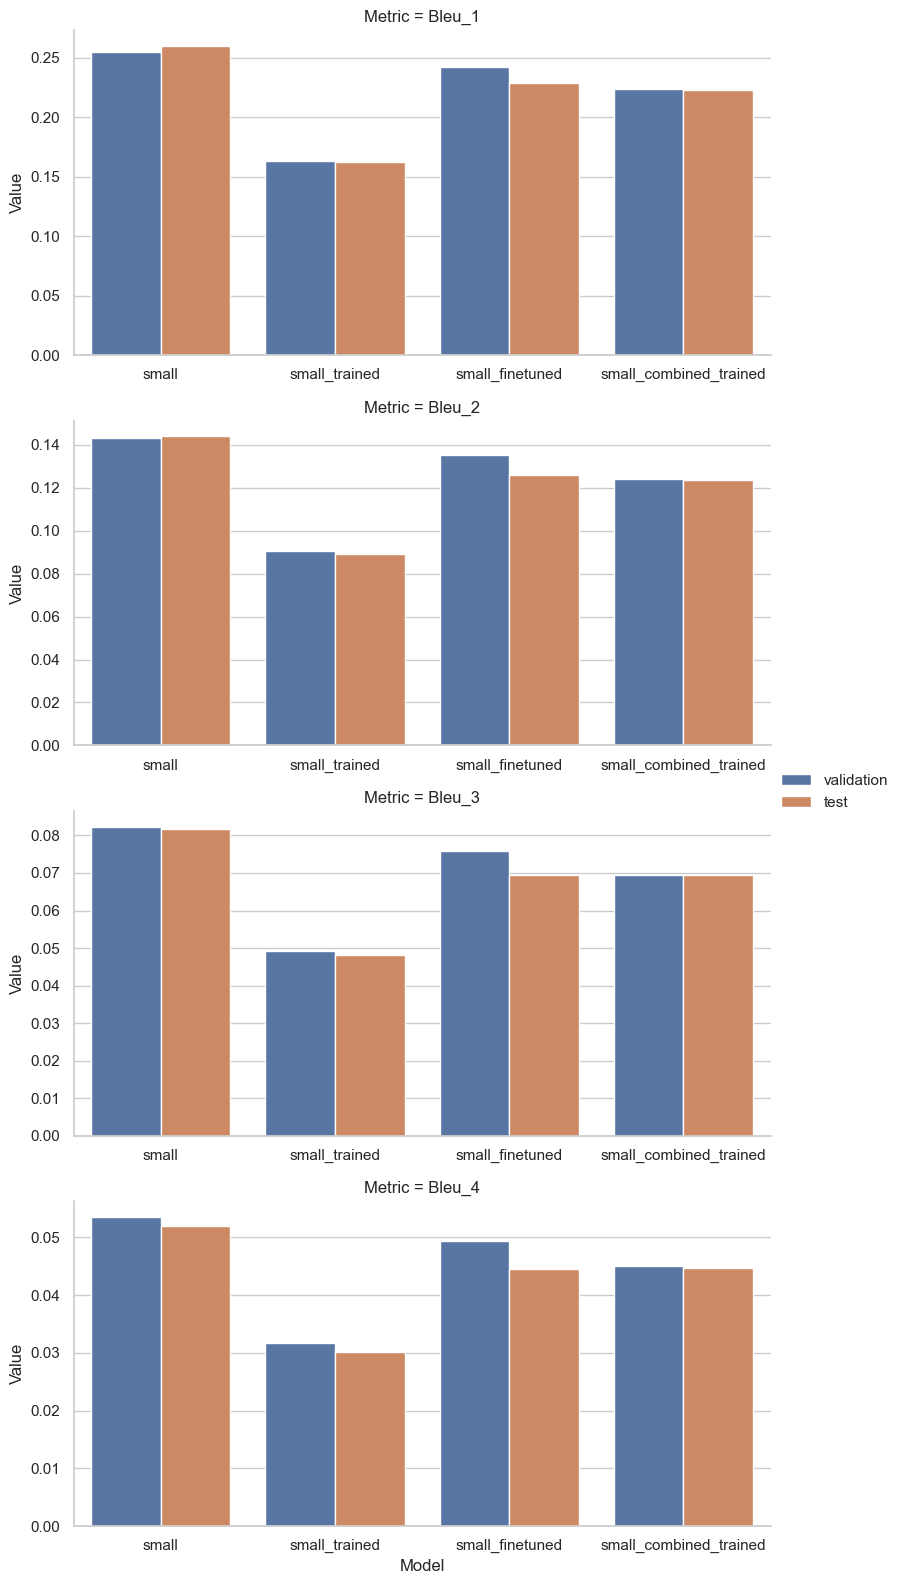

In [38]:
def plot_results(df):
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df, row="Metric", height=4, aspect=2, sharex=False, sharey=False)
    g.map(sns.barplot, "Model", "Value", "Dataset", palette="deep", order=["small","small_trained","small_finetuned","small_combined_trained","small_trained"])
    g.add_legend()

plot_results(df[df["Metric"].str.contains("Bleu")])

Erkenntnisse:
- small (baseline) ist immer am besten
- small_trained schneidet immer schlechter ab als alle anderen
- small_finetuned schneidet am besten ab von den selbst trainierten Modellen
- small_finetuned hat aber immer einen höheren Validation BLEU als Test BLEU
- small_combined_trained schneiden in validation und test etwa gleich ab wie small_finetuned im test


d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


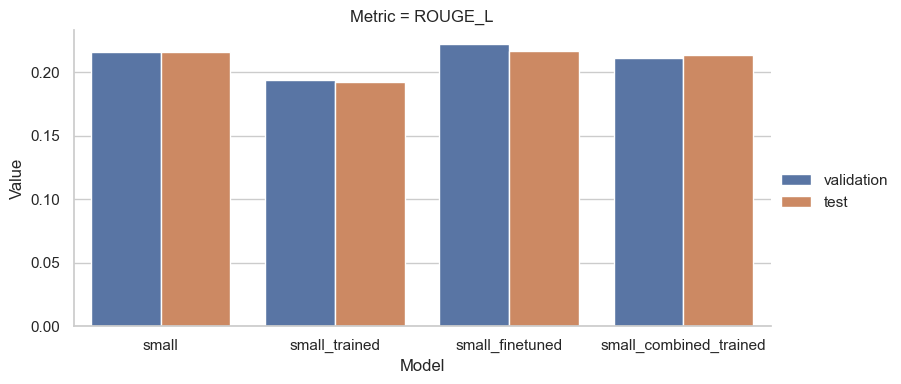

In [42]:
plot_results(df[df["Metric"] == "ROUGE_L"])

Erkenntnisse:
- ROUGE_L:
    - finetuned schneidet im Test vergleichbar mit baseline ab, Validation ist bisschen besser
    - trained wieder deutlich schlechter
    - combined_trained etwa gleich wie baseline

d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


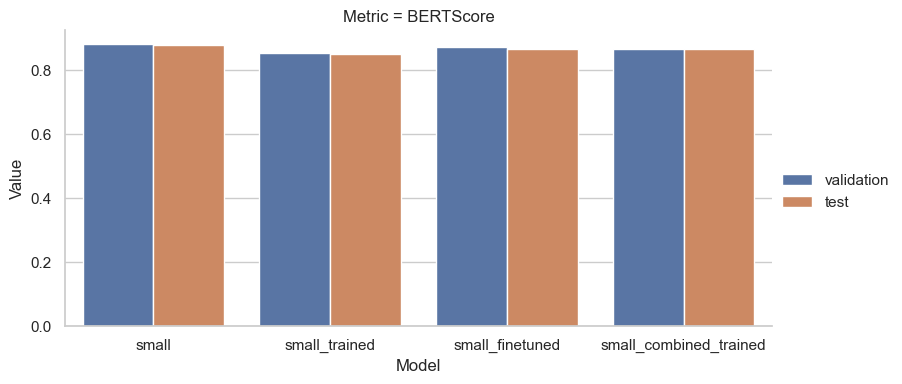

In [43]:
plot_results(df[df["Metric"] == "BERTScore"])

Erkenntnisse:
- BERTScore unterscheidet sich nicht wirklich zwischen den Modellen


d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


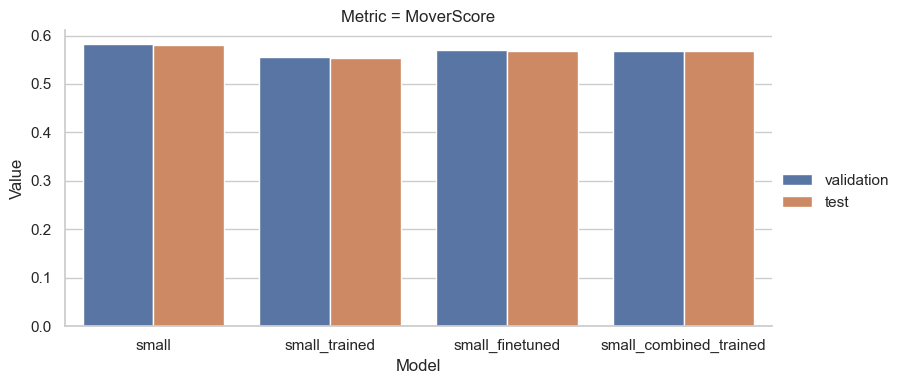

In [44]:
plot_results(df[df["Metric"] == "MoverScore"])

Erkenntnisse:
 - Alle schlechter als baseline
 - trained am schlechtesten
 - finetuned und combined_trained etwa gleich gut

d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


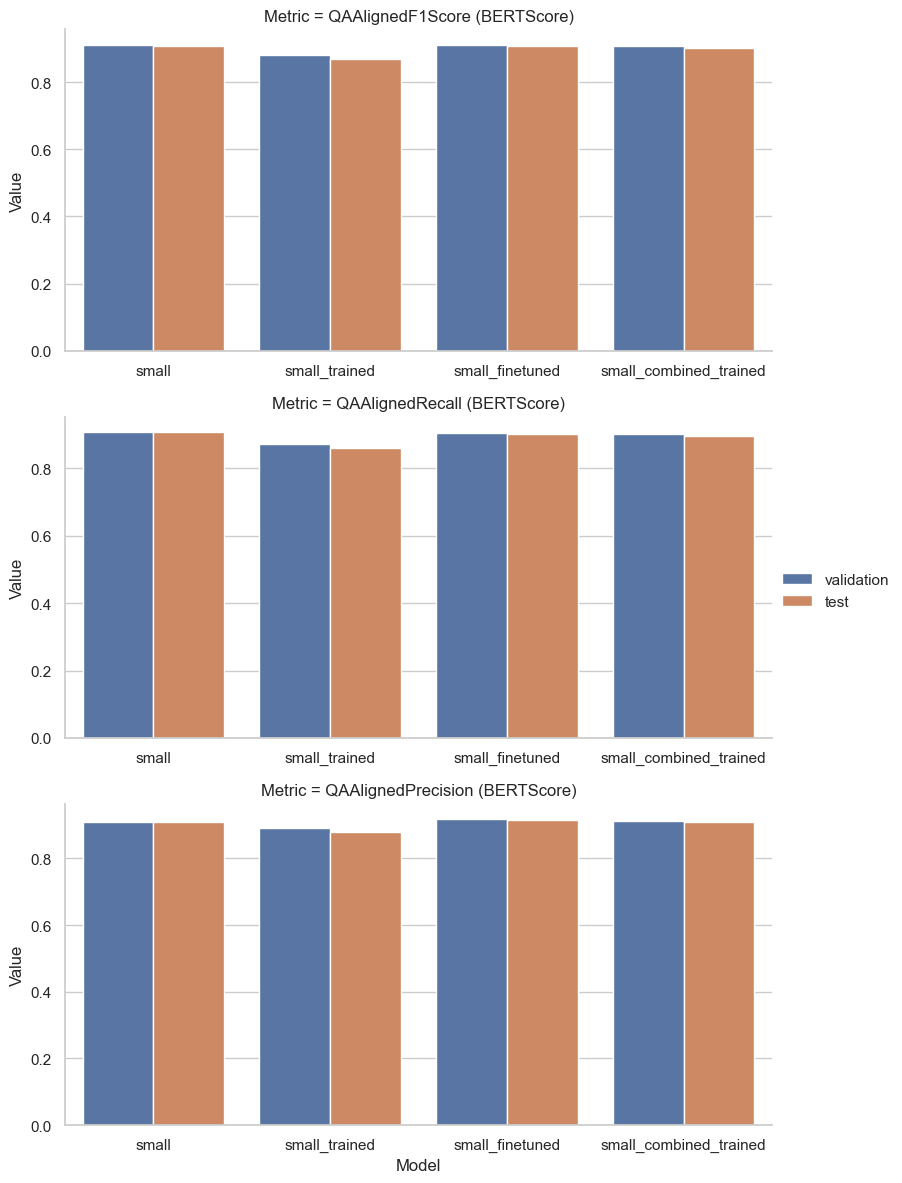

In [46]:
plot_results(df[df["Metric"].str.contains("(BERTScore)", regex=False)])

Sind in etwa alle gleich gut, trained immer ein wenig schlechter. Einzig bei Precision ist small_finetuned minimal besser als baseline.

d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


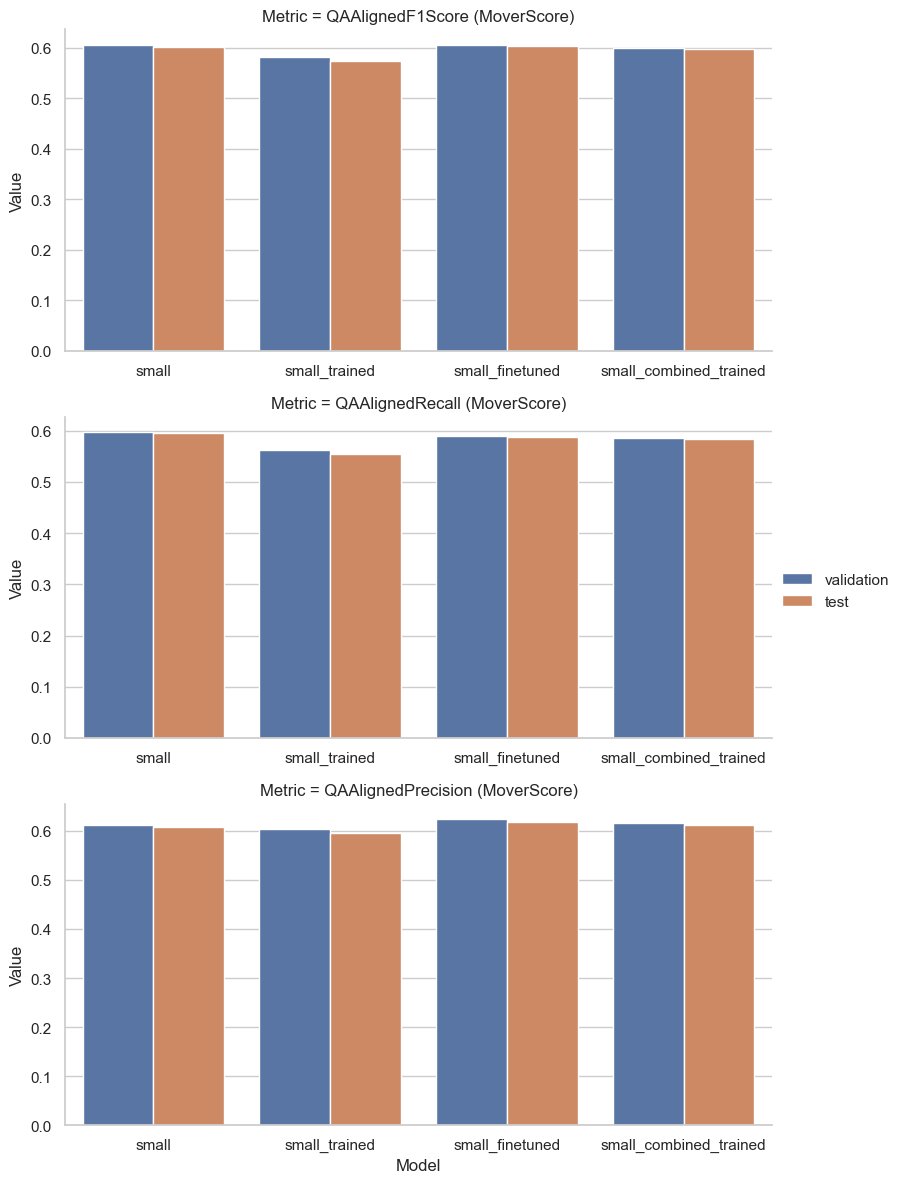

In [47]:
plot_results(df[df["Metric"].str.contains("(MoverScore)", regex=False)])

gleich wie bei BERTScore

In [65]:
# open this file and randomly pick 3 lines: evaluation_small_trained  \samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt
# open this file and randomly pick 3 lines: evaluation_small_finetuned\samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt

paragraphs = []
with open("./evaluation_small_finetuned/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt", "r", encoding="UTF-8") as file:
    for line in file:
        paragraphs.append(line)

picked_paragraphs = []
import random
random.seed(42)
for i in range(3):
    picked_paragraphs.append(random.choice(paragraphs))
    
parsed_paragraphs = []
for paragraph in paragraphs:
    q_and_as = []
    for q_and_a in paragraph.split(" | "):
        try:
            q_and_as.append({
                "Question": q_and_a.split(", answer:")[0],
                "Answer": q_and_a.split(", answer:")[1].strip()
            })
        except IndexError:
            print("Error parsing the following question and answer:")
            print(q_and_a)
    parsed_paragraphs.append(q_and_as)

for q_and_a in parsed_paragraphs[0]:
    print(q_and_a["Question"])
    print(q_and_a["Answer"])
    print()

Error parsing the following question and answer:
question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently.
Error parsing the following question and answer:
question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently.
Error parsing the following question and answer:
question: Who called several Republicans trying to persuade them to support a bill that would reverse a 10.6 percent cut in Medicare payments to doctors.
Error parsing the following question and answer:
question: Who will make the announcement at "an event in Washington, D.C.," answer: Sen. Hillary Clinton
Error parsing the following question and answer:
question: Who will make the announcement at "an event in Washington, D.C.," answer: Hillary Clinton

Error parsing the following question and answer:
question: How many Republicans, including three seeking re-election in Novem

In [66]:
parsed_paragraphs

[[{'Question': 'question: What is PAYGO?',
   'Answer': 'a record $1.8 trillion deficit'},
  {'Question': 'question: What does PAYGO require?',
   'Answer': 'lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere'},
  {'Question': 'question: What does PAYGO require?',
   'Answer': 'lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere'},
  {'Question': 'question: What does PAYGO require?',
   'Answer': 'lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere'}],
 [{'Question': 'question: Who will address the future of the U.S. military prison at?',
   'Answer': 'President Obama'},
  {'Question': 'question: Who will address the future of the U.S. military prison?',
   'Answer': 'President Obama'},
  {'Question': 'question: Who will address the future of the U.S. military prison?',
   'Answer': 'President Obama'},
  {'Question': 'question: Who will address the future of the U.S. military prison?',
   'Answer': 

Some stuff I noticed:
 - the same questions are generated multiple times
 - Not all questions and answers are parsaable by the model
 - many paragraphs with all the same questions
 - sometimes the answers get more detailed with every repetition
 ```json
 [{'Question': 'question: How many mushers and dog teams are on the wide-open trail toward Nome?',
   'Answer': '71'},
  {'Question': 'question: How many mushers and dog teams are on the wide-open trail toward Nome?',
   'Answer': '71'},
  {'Question': 'question: Who is a throat cancer survivor?',
   'Answer': 'Lance Mackey'},
  {'Question': 'question: Who is a throat cancer survivor?',
   'Answer': 'Lance Mackey, 39,'},
  {'Question': 'question: Who is a throat cancer survivor?',
   'Answer': 'Lance Mackey, 39, of Fairbanks, Alaska'}],
```
- sometimes the answers cannot be correct.
 ```json
 [{'Question': 'question: How many additional U.S. troops were deployed to Afghanistan?',
   'Answer': '30,000'},
  {'Question': 'question: How many troops did Obama send to Afghanistan?',
   'Answer': '30,000'},
  {'Question': 'question: How many troops did Obama send to Afghanistan?',
   'Answer': '30,000'},
  {'Question': 'question: How many troops did Obama send to Afghanistan?',
   'Answer': '30,000'},
  {'Question': 'question: How many troops did Obama send to Afghanistan?',
   'Answer': '30,000'},
  {'Question': 'question: How many troops did Obama send to Afghanistan?',
   'Answer': '30,000'}],
 ```

## Verbesserungvorschläge und dazugehörige Evaluation

## Erklärung

## Weitere Ideen

## Fazit